In [1]:
%pylab inline
import numpy as np
import pylab as pl

Populating the interactive namespace from numpy and matplotlib


# 支持向量机

支持向量机有两种：SVC，支持向量分类，用于分类问题；SVR,支持向量回归，用于回归问题。

In [2]:
from sklearn import svm

## 线性支持向量机（Linear SVMs）:一些感性认识

我们采用一个非常有名的用于分类问题的数据集：鸢尾花数据集。它是基于鸢尾花的花萼的长度和宽度进行分类的。我们只用其中两维特征，这能够方便可视化。

In [3]:
svc = svm.SVC(kernel='linear')
# 鸢尾花数据集是sklearn自带的。
from sklearn import datasets
iris = datasets.load_iris()
# 只提取前面两列数据作为特征
X = iris.data[:, :2]
y = iris.target
# 基于这些数据训练出一个支持向量分离器SVC
svc.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

将预测结果可视化

In [4]:
from matplotlib.colors import ListedColormap
# 因为鸢尾花是3分类问题，我们要对样本和预测结果均用三种颜色区分开。
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_estimator(estimator, X, y):
    '''
    这个函数的作用是基于分类器，对预测结果与原始标签进行可视化。
    '''
    estimator.fit(X, y)
    # 确定网格最大最小值作为边界
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    # 产生网格节点
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    # 基于分离器，对网格节点做预测
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # 对预测结果上色
    Z = Z.reshape(xx.shape)
    pl.figure()
    pl.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # 同时对原始训练样本上色
    pl.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    pl.axis('tight')
    pl.axis('off')
    pl.tight_layout()

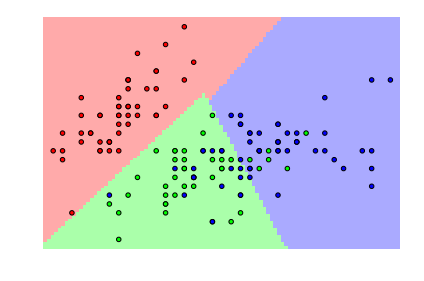

In [5]:
plot_estimator(svc, X, y)

* 正如我们所见，`kernel="linear"`（线性核函数）给了我们线性的决策边界：两类之间的分离边界是直线。
* 多分类的工作方式就是"one versus one" ：在任意两类样本之间设计一个SVM，因此k个类别的样本就需要设计k(k-1)/2个SVM。当对一个未知样本进行分类时，最后得票最多的类别即为该未知样本的类别。
* **线性支持向量分类器（LinearSVC）**：对于线性核函数，有一个新的对象`LinearSVC` ，它使用了不同的算法。在某些数据集上运行地更快（比如稀疏数据集，文本挖掘就是典型的例子）。它对于多分类采用的是"one versus all"策略。

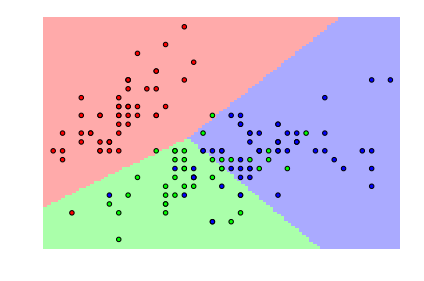

In [6]:
plot_estimator(svm.LinearSVC(), X, y)

## 支持向量与正则化

* **支持向量**：就是最靠近分离边界的样本点。支持向量机的工作方式就是找到这些支持向量，它们被认为是在二分类问题中最具代表性的样本点。
* 为了更方便的可视化，我们选择二分类问题，也就是只考虑鸢尾花数据集中的1类和2类样本。这两类不是线性可分的，所以我们可以看到更有趣的一些东西。
* 支持向量的坐标可以通过方法`support_vectors_`来找到。我们在图中将对它们着重标记。

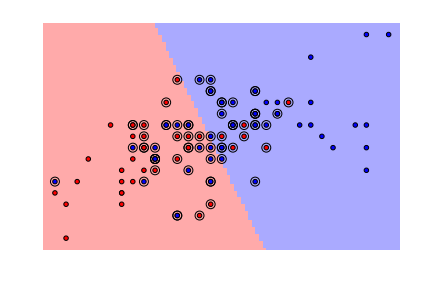

In [7]:
X, y = X[np.in1d(y, [1, 2])], y[np.in1d(y, [1, 2])]
plot_estimator(svc, X, y)
pl.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, facecolors='none', zorder=10)

* **正则化** ：只考虑支持向量其实就是一种正则化的形式。实际上，它强迫模型在处理样本特征的时候变得更加简单。
This regularization can be tuned with the *C* parameter:
* 正则项可以通过调整系数 *C* 来决定：
  - 小的C值：将会有很多支持向量。决策边界=类别A的平均值-类别B的平均值
  - 大的C值：将会有较少的支持向量。决策边界是被大多数支持向量所决定。

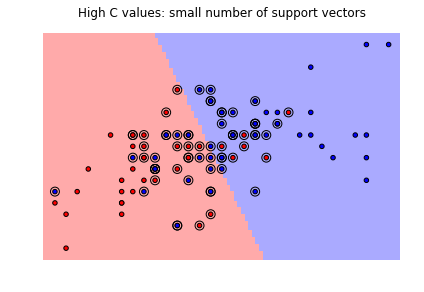

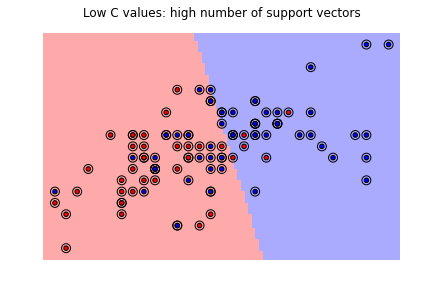

In [8]:
svc = svm.SVC(kernel='linear', C=1e3)
plot_estimator(svc, X, y)
pl.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, facecolors='none', zorder=10)
pl.title('High C values: small number of support vectors')

svc = svm.SVC(kernel='linear', C=1e-3)
plot_estimator(svc, X, y)
pl.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, facecolors='none', zorder=10)
pl.title('Low C values: high number of support vectors')

* 支持向量机的有个好处是对于许多数据集，默认参数'C=1'其实工作得很好。
* **实践经验：对样本正则化**： 对于许多分离器，采用标准差正则方法是非常重要的提升预测效果的手段。

## 核方法

采用核方法，能够很方便地产生非线性分类边界。

- **linear**，线性核，会产生线性分类边界。一般来说它的计算效率最高，而且需要数据最少。
- **poly** ，多项式核，会产生多项式分类边界。
- **rbf**，径向基函数，也就是高斯核，是根据与每一个支持向量的距离来决定分类边界的。它的映射到无线维的。它是最灵活的方法，但是也需要最多的数据。

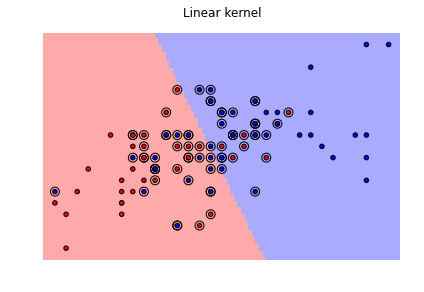

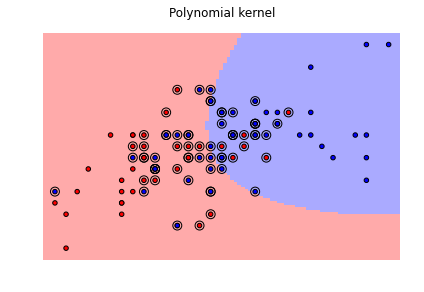

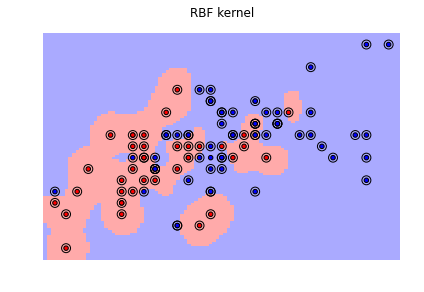

In [9]:
svc = svm.SVC(kernel='linear')
plot_estimator(svc, X, y)
pl.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, facecolors='none', zorder=10)
pl.title('Linear kernel')

svc = svm.SVC(kernel='poly', degree=4)
plot_estimator(svc, X, y)
pl.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, facecolors='none', zorder=10)
pl.title('Polynomial kernel')

svc = svm.SVC(kernel='rbf', gamma=1e2)
plot_estimator(svc, X, y)
pl.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, facecolors='none', zorder=10)
pl.title('RBF kernel')

我们可以看到，高斯核更灵活，而且对于训练数据效果是最好的。但是要担心过拟合。